In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import datetime
import pandas as pd
import numpy as np
from functools import partial
from dateutil import parser as dtparser

from utils.datafetch import *
from utils.vectorized_funs import *
from utils.datapipe import *
from utils.kerasutil import *
from FintechCapstone import FinCapstone

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import print_function

#%matplotlib inline

plt.style.use('seaborn-whitegrid')

- ~~Simple Moving Average~~
- ~~Bollinger Bands~~~
- ~~Relative Strength Index~~
- ~~Stochastic Oscillator~~
- ~~MACD~~
- ~~on-balance volume~~
- ~~Accumulation/Distribution Lines~~
- ~~Average Directional Index~~~
- ~~Aroon Indicator~~~

In [33]:
date_from = '2009-01-01'
date_to = '2017-03-01'
timespan = {
    "short_term": [1, 5]
    ,"medium_term": [40]
    ,"long_term": [90]
}

timespan_ab = {
    "short_term": []
    ,"medium_term": [30]
    ,"long_term": []
}

trial = FinCapstone(ticker_list=["AAPL", "EBAY", "GOOG", "DIS", "NFLX", "EA", "TWTR"], ticker_list_samplesize=4, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)
#trial = FinCapstone(ticker_list_samplesize=200, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)

#trial.run_initial_dataload()
#trial.feature_engineering(feature_set="baseline")





In [8]:
_ticker = "NFLX"

_slice_limit = -252 * 8

def load_dataframes(ticker, limit):
    #Load Dataframes
    raw_df = load_raw_frame(ticker, tryfetch=True)
    sma_df = calc_sma(raw_df, {"short": [5,10,30,60,90,200]}, ["Close", "Open", "High", "Low", "Volume"], merge_result=False)
    boll_df = calc_bollinger(raw_df, {"long_term": [5,10,30,60,90,200]}, ["Close", "Open", "High", "Low", "Volume"], merge_result=False)

    sma_df.set_index(raw_df["Date"], inplace=True)
    boll_df.set_index(raw_df["Date"], inplace=True)
    raw_df.set_index("Date", inplace=True)

    raw_df = raw_df.iloc[limit:]
    sma_df = sma_df.iloc[limit:]
    boll_df = boll_df.iloc[limit:]
    
    return raw_df, sma_df, boll_df

def plot_ticker(ticker, limit, raw_df=None):
    if raw_df is None:
        raw_df, sma_df, boll_df = load_dataframes(ticker, limit)
    
    baseline_X = trial.load_baseline_features(ticker, parseDate=True)
    baseline_X.set_index("Date", inplace=True)
    baseline_X = baseline_X.iloc[limit:]
    baseline_y = trial.load_baseline_labels(ticker, parseDate=True)
    baseline_y.set_index("Date", inplace=True)
    baseline_y = baseline_y.iloc[limit:]

    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    volume_hist = fig.add_subplot(grid[-1:,:])
    main_ax = fig.add_subplot(grid[:-1, :], sharex=None)


    #Main Plot
    main_ax.plot(x, raw_df["Adj Close"], '-r', label="Adj Close")
    main_ax.plot(x, raw_df["Close"], '-g', label="Close")
    main_ax.plot(x, raw_df["Low"], ':b', label="Low")
    main_ax.plot(x, raw_df["High"], ':b', label="High")


    #Volume Plot
    volume_hist.bar(x, raw_df["Volume"])

    #setting legends
    main_ax.legend(prop={'size':11})


    # rotating ticks
    for tick in volume_hist.get_xticklabels():
        tick.set_rotation(30)


    plt.show()

In [9]:
def plot_sma(raw_df, sma_df):
    
    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    volume_hist = fig.add_subplot(grid[-1:,:])
    main_ax = fig.add_subplot(grid[:-1, :], sharex=None)


    #Main Plot
    main_ax.plot(x, raw_df["Close"], '-g', label="Close")
    main_ax.plot(x, sma_df["Close_roll_mean_5"], ':b', label="SMA(5)")
    main_ax.plot(x, sma_df["Close_roll_mean_10"], ':y', label="SMA(10)")
    main_ax.plot(x, sma_df["Close_roll_mean_30"], ':r', label="SMA(30)")


    #Volume Plot
    volume_hist.bar(x, raw_df["Volume"])

    #setting legends
    main_ax.legend(prop={'size':11})


    # rotating ticks
    for tick in volume_hist.get_xticklabels():
        tick.set_rotation(30)

    plt.show()

In [10]:
def plot_bollingers(raw_df, boll_df):
    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(20, 15))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    five_ax = fig.add_subplot(grid[0, :])
    ten_ax = fig.add_subplot(grid[1, :])
    thirty_ax = fig.add_subplot(grid[2, :])
    all_ax = fig.add_subplot(grid[3, :])

    #Interval Plots
    five_ax.plot(x, raw_df["Close"], '-g', label="Close")
    five_ax.plot(x, boll_df["Close_bollinger_5_up"], ':y', label="bollinger(5)")
    five_ax.plot(x, boll_df["Close_bollinger_5_low"], ':y', label="bollinger(5)")
    five_ax.fill_between(x, boll_df["Close_bollinger_5_low"], boll_df["Close_bollinger_5_up"], color="#d4d424", alpha=0.2)


    ten_ax.plot(x, raw_df["Close"], '-g', label="Close")
    ten_ax.plot(x, boll_df["Close_bollinger_10_up"], ':r', label="bollinger(10)")
    ten_ax.plot(x, boll_df["Close_bollinger_10_low"], ':r', label="bollinger(10)")
    ten_ax.fill_between(x, boll_df["Close_bollinger_10_low"], boll_df["Close_bollinger_10_up"], color="#be2121", alpha=0.2)


    thirty_ax.plot(x, raw_df["Close"], '-g', label="Close")
    thirty_ax.plot(x, boll_df["Close_bollinger_30_up"], ':b', label="bollinger(30)")
    thirty_ax.plot(x, boll_df["Close_bollinger_30_low"], ':b', label="bollinger(30)")
    thirty_ax.fill_between(x, boll_df["Close_bollinger_30_low"], boll_df["Close_bollinger_30_up"], color="#3737f5", alpha=0.2)


    # Full Plot
    all_ax.plot(x, boll_df["Close_bollinger_30_up"], ':b', label="bollinger(30)")
    all_ax.plot(x, boll_df["Close_bollinger_30_low"], ':b', label="bollinger(30)")
    all_ax.fill_between(x, boll_df["Close_bollinger_30_low"], boll_df["Close_bollinger_30_up"], color="#3737f5", alpha=0.15)

    all_ax.plot(x, boll_df["Close_bollinger_10_up"], ':r', label="bollinger(10)")
    all_ax.plot(x, boll_df["Close_bollinger_10_low"], ':r', label="bollinger(10)")
    all_ax.fill_between(x, boll_df["Close_bollinger_10_low"], boll_df["Close_bollinger_10_up"], color="#be2121", alpha=0.15)

    all_ax.plot(x, boll_df["Close_bollinger_5_up"], ':y', label="bollinger(5)")
    all_ax.plot(x, boll_df["Close_bollinger_5_low"], ':y', label="bollinger(5)")
    all_ax.fill_between(x, boll_df["Close_bollinger_5_low"], boll_df["Close_bollinger_5_up"], color="#d4d424", alpha=0.15)


    all_ax.plot(x, raw_df["Close"], '-g', label="Close")

    #setting legends
    five_ax.legend(prop={'size':11})
    ten_ax.legend(prop={'size':11})
    thirty_ax.legend(prop={'size':11})
    all_ax.legend(prop={'size':11})

    plt.show()

In [11]:
def plot_bollinger_single(raw_df, boll_df, sma_df):
    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(20, 15))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    thirty_ax = fig.add_subplot(grid[0:3, :])

    #Interval Plots
    thirty_ax.fill_between(x, boll_df["Close_bollinger_30_low"], boll_df["Close_bollinger_30_up"], color="#3737f5", alpha=0.05)
    thirty_ax.plot(x, boll_df["Close_bollinger_30_up"], ':b', label="bollinger(30)")
    thirty_ax.plot(x, boll_df["Close_bollinger_30_low"], ':b', label="bollinger(30)")
    thirty_ax.plot(x, raw_df["Close"], '-g', label="Close")
    thirty_ax.plot(x, raw_df["High"], ':g', label="High", color="#FF0000")
    thirty_ax.plot(x, raw_df["Low"], ':g', label="Low", color="#FF0000")
    thirty_ax.plot(x, sma_df["Close_roll_mean_30"], '-b', label="SMA(30)", alpha=0.2)


    #setting legends
    thirty_ax.legend(prop={'size':11})


    plt.show()

In [12]:
def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100.0 - 100./(1. + rs)
    
    for i in range(n, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        
        up = (up*(n-1) + upval) / n
        down = (down*(n-1)+downval)/n
        
        rs = up/down
        rsi[i] = 100. - 100 / (1.+rs)
    
    return rsi

def plot_rsi(raw_df):
    rsi = rsiFunc(raw_df["Close"])
    
    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    rsi_ax = fig.add_subplot(grid[-1:,:])
    main_ax = fig.add_subplot(grid[:-1, :], sharex=None)


    #Main Plot
    main_ax.plot(x, raw_df["Close"], '-g', label="Close")

    #RSI Plot
    rsi_ax.plot(x, rsi)
    
    # RSI Plot - drawing the limits
    rsi_ax.axhline(70, linewidth=0.5)
    rsi_ax.axhline(30, linewidth=0.5)

    #setting legends
    main_ax.legend(prop={'size':11})

    plt.show()

In [13]:
def onbalancevolumeFunc(daily_returns, volume):
    _r = None
    
    _signal = daily_returns.copy()
    _signal.where(_signal >= 0, -1, inplace=True)
    _signal.where(_signal < 0, 1, inplace=True)
    
    _r = volume * _signal

    return _r.cumsum()


def plot_obv(raw_df, ticker, limit):
    # get our x ticks
    x = raw_df.index.tolist()
    
    baseline_y = trial.load_baseline_labels(ticker, parseDate=True)
    baseline_y.set_index("Date", inplace=True)
    baseline_y = baseline_y.iloc[limit:]

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.2)

    price_ax = fig.add_subplot(grid[0, :], sharex=None)
    return_ax = fig.add_subplot(grid[1,:])    
    volume_ax = fig.add_subplot(grid[2,:])
    obv_ax = fig.add_subplot(grid[3,:])

    obv = onbalancevolumeFunc(baseline_y["timewindow_return_1_Close"], raw_df["Volume"])

    price_ax.plot(x, raw_df["Close"], '-g', label="Close")
    return_ax.plot(x, baseline_y["timewindow_return_1_Close"], label="Daily Return")
    volume_ax.bar(x, raw_df["Volume"], label="Volume")
    obv_ax.bar(x, obv, label="OBV")
    
    

    #setting legends
    price_ax.legend(prop={'size':11})
    volume_ax.legend(prop={'size':11})

    plt.show()



In [14]:
def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights = weights / weights.sum()
    a = np.convolve(values, weights, mode="full")[:values.shape[0]]
    a[:window] = a[window]
    return a

def calc_macd(x, slow=26, fast=12):
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return emaslow, emafast, emafast - emaslow

def plot_macd(raw_df):
    nslow = 26
    nfast = 12
    nema = 9

    emaslow, emafast, macd = calc_macd(raw_df["Close"], nslow, nfast)
    ema9 = ExpMovingAverage(macd, nema)

    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    macd_ax = fig.add_subplot(grid[:1,:])

    macd_ax.plot(x, macd)
    macd_ax.plot(x, ema9)
    macd_ax.fill_between(x, macd-ema9, 0, alpha=0.5, facecolor="#FF4444", edgecolor="#FF4444")


    plt.show()

In [15]:

def calc_stochasticoscilator(raw_df, window=14):
    max_hi = raw_df["High"].rolling(window=window).max()
    min_lo = raw_df["Low"].rolling(window=window).min()

    return (raw_df["Close"] - min_lo) / (max_hi - min_lo) * 100.0

def plot_stochasticoscilator(raw_df):
    window = 14

    stosc = calc_stochasticoscilator(raw_df, window)
    stosc_ma30 = stosc.rolling(window=3).mean()

    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 1, hspace=0.2, wspace=0.2)

    prices_ax = fig.add_subplot(grid[:3, :])
    stosc_ax = fig.add_subplot(grid[3,:])
    
    prices_ax.plot(x, raw_df["Adj Close"], '-g', label="Adj Close")
    stosc_ax.plot(x, stosc, "-r", label="Oscilator", linewidth=0.5)
    stosc_ax.plot(x, stosc_ma30, "-k", label="SMA(3)", linewidth=0.5)
    
    stosc_ax.axhline(80, linewidth=0.5, color="blue")
    stosc_ax.axhline(50, linewidth=0.5, color="blue")
    stosc_ax.axhline(20, linewidth=0.5, color="blue")

    stosc_ax.legend(prop={'size':11})
    prices_ax.legend(prop={'size':11})

    plt.show()
    

In [16]:
def calc_adx(raw_df):
    yesterdayclose = raw_df["Close"].shift(1)

    atr_df = pd.DataFrame()
    atr_df["H-L"] = raw_df["High"] - raw_df["Low"]
    atr_df["H-YC"] = np.abs(raw_df["High"] - yesterdayclose)
    atr_df["L-YC"] = np.abs(raw_df["Low"] - yesterdayclose)
    atr_df["TR"] = atr_df.max(axis=1)
    atr = ExpMovingAverage(atr_df["TR"], 14)

    moveup = raw_df["High"] - raw_df["High"].shift(1)
    movedown = raw_df["Low"].shift(1) - raw_df["Low"]


    pdm = moveup.where((moveup <= 0) | (moveup <= movedown), 0)
    ndm = movedown.where((movedown <= 0) | (movedown <= moveup), 0)

    pdm_ema14 = ExpMovingAverage(pdm, 14)
    ndm_ema14 = ExpMovingAverage(ndm, 14)

    pdi = (pdm_ema14 / atr) * 100.0
    ndi = (ndm_ema14 / atr) * 100.0

    adx = 100.0 * ExpMovingAverage(np.abs((pdi - ndi)), 14) / (pdi + ndi)
    
    return adx, pdi, ndi

def plot_atr(raw_df):

    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    adx_ax = fig.add_subplot(grid[1::,:])
    main_ax = fig.add_subplot(grid[0, :],)
    
    adx, pdi, ndi = calc_adx(raw_df)


    #Main Plot
    main_ax.plot(x, raw_df["Close"], '-g', label="Close")


    #Volume Plot
    adx_ax.plot(x, adx, "-g", label="Avg Dir. Index")
    adx_ax.plot(x, pdi, "-c", label="+DI")
    adx_ax.plot(x, ndi, "-m", label="-DI")

    #setting legends
    main_ax.legend(prop={'size':11})
    adx_ax.legend(prop={'size':11})
    


    plt.show()


In [17]:
def time_sincelastmax(windowframe, aroon_df):
    argmax_h = np.argmax(aroon_df["H"].iloc[windowframe.astype(np.int)])
    #argmax_date = aroon_df.loc[argmax_h, "Date"]
    #today_date = aroon_df.loc[windowframe[-1], "Date"]
    return (windowframe[-1] - argmax_h)

def time_sincelastmin(windowframe, aroon_df):
    argmin_h = np.argmin(aroon_df["L"].iloc[windowframe.astype(np.int)])
    #argmin_date = aroon_df.loc[argmin_h, "Date"]
    #today_date = aroon_df.loc[windowframe[-1], "Date"]
    return (windowframe[-1] - argmin_h)

def calc_aroon(raw_df, window=25):

    aroon_df = pd.DataFrame()
    aroon_df["Date"]= pd.Series(raw_df.index.tolist())
    aroon_df["H"] = raw_df["High"].values
    aroon_df["LAST_H"] = pd.Series(np.arange(aroon_df.shape[0]).astype(np.int32)).rolling(window=window).apply(time_sincelastmax, args=[aroon_df])
    aroon_df["L"] = raw_df["Low"].values
    aroon_df["LAST_L"] = pd.Series(np.arange(aroon_df.shape[0]).astype(np.int32)).rolling(window=window).apply(time_sincelastmin, args=[aroon_df])
    aroon_df["AROON_UP"] = ((window - aroon_df["LAST_H"]) / float(window)) * 100.0
    aroon_df["AROON_DOWN"] = ((window - aroon_df["LAST_L"]) / float(window)) * 100.0
    
    return aroon_df["AROON_UP"], aroon_df["AROON_DOWN"]


def plot_aroon(raw_df):
    aroon_up, aroon_down = calc_aroon(raw_df, 20)

    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 1, hspace=0.2, wspace=0.2)

    prices_ax = fig.add_subplot(grid[:3, :])
    aroon_ax = fig.add_subplot(grid[3,:])
    
    prices_ax.plot(x, raw_df["Adj Close"], '-c', label="Adj Close")
    aroon_ax.plot(x, aroon_up, "-g", label="Aroon Up", linewidth=0.5)
    aroon_ax.plot(x, aroon_down, "-r", label="Aroon Down", linewidth=0.5)
    
    
    aroon_ax.legend(prop={'size':11})
    prices_ax.legend(prop={'size':11})

    plt.show()
    

In [18]:
def calc_chaikin_money_flow(raw_df, window=21):
    window = 21
    dmf = (((raw_df["Close"] - raw_df["Low"]) - (raw_df["High"] - raw_df["Close"])) / (raw_df["High"] - raw_df["Low"])) * raw_df["Volume"]
    cmf = dmf.rolling(window=window).mean() / raw_df["Volume"].rolling(window=window).mean()
    return cmf, dmf

def plot_chaikin_money_flow(raw_df):
    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(6, 4, hspace=0.4, wspace=0.2)

    cmf_ax = fig.add_subplot(grid[2:4,:])
    dmf_ax = fig.add_subplot(grid[4:,:])
    main_ax = fig.add_subplot(grid[:2, :], sharex=cmf_ax)
    
    cmf, dmf = calc_chaikin_money_flow(raw_df)
    
    #Volume Plot
    cmf_ax.plot(x, cmf, "-c", label="Chaikin Money Flow")
    
    dmf_ax.plot(x, dmf, "-b", label="Daily Money Flow")
    
    #Main Plot
    main_ax.plot(x, raw_df["Close"], '-g', label="Close")




    #setting legends
    main_ax.legend(prop={'size':11})
    cmf_ax.legend(prop={'size':11})
    dmf_ax.legend(prop={'size':11})
    


    plt.show()

------

In [19]:
raw_df, sma_df, boll_df = load_dataframes(_ticker, _slice_limit)

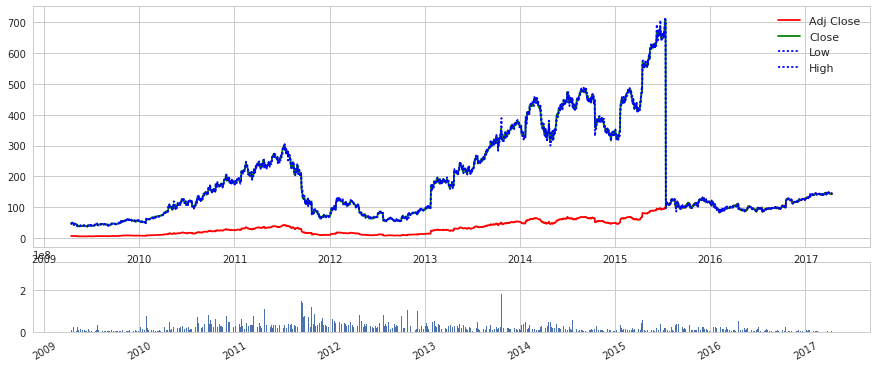

In [76]:
plot_ticker(_ticker, _slice_limit, raw_df)

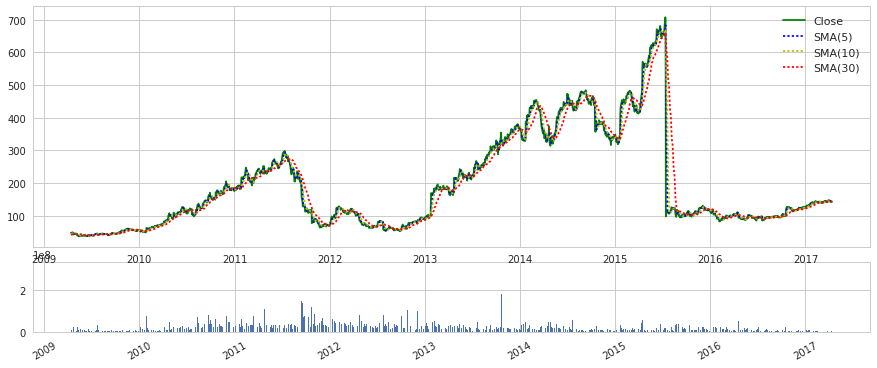

In [77]:
plot_sma(raw_df, sma_df)

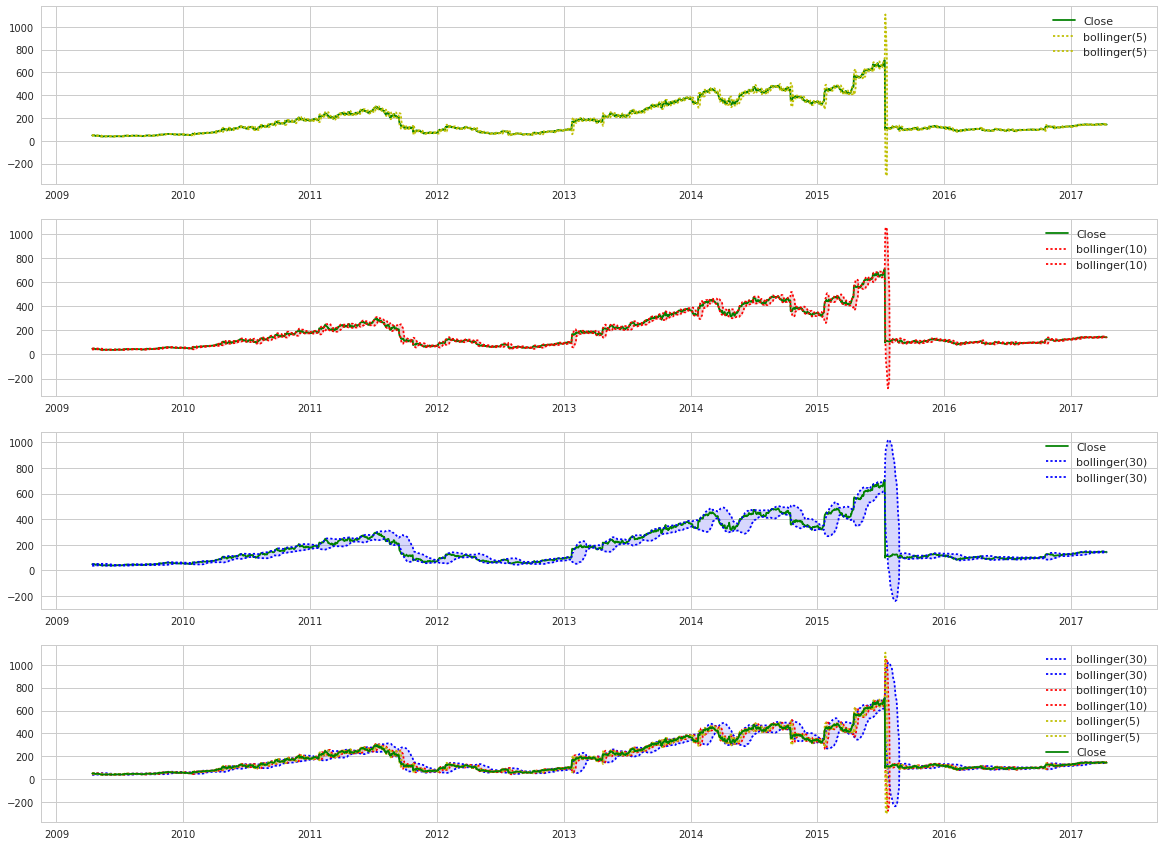

In [78]:
plot_bollingers(raw_df, boll_df)

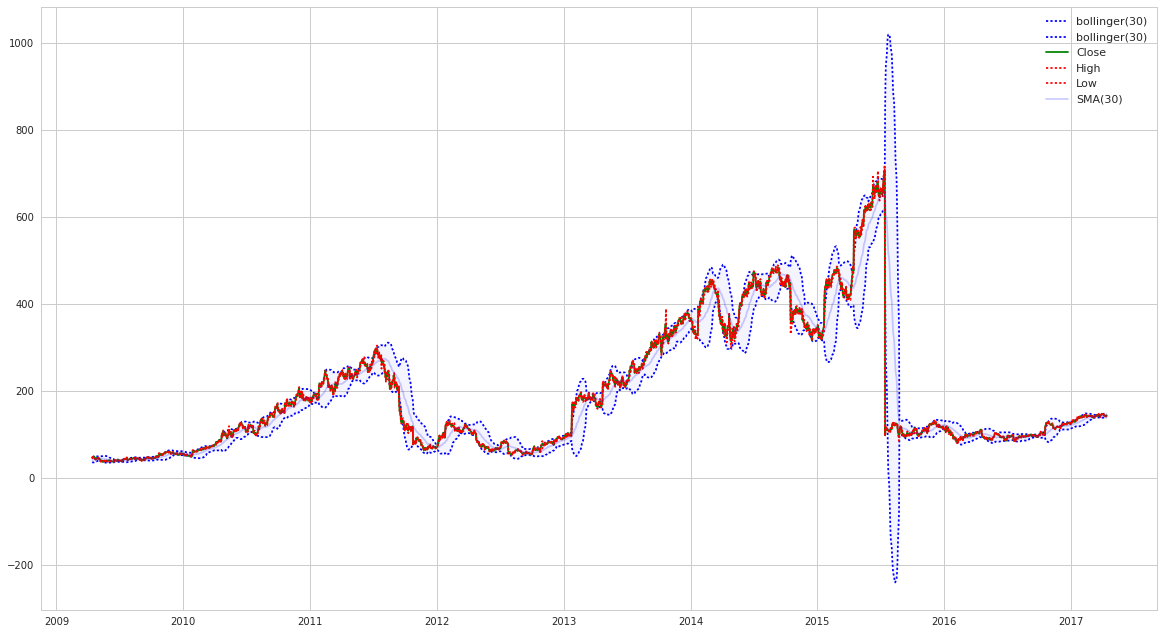

In [79]:
plot_bollinger_single(raw_df, boll_df, sma_df)

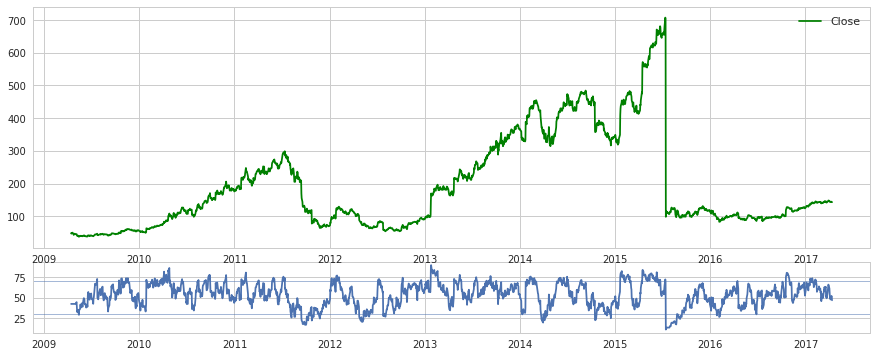

In [80]:
plot_rsi(raw_df)

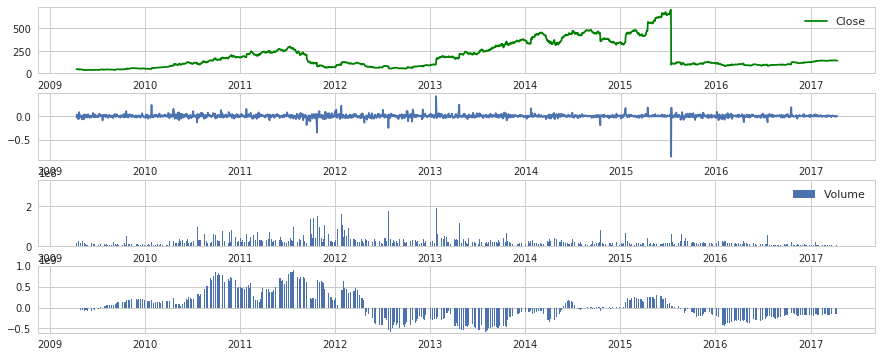

In [81]:
plot_obv(raw_df, _ticker, _slice_limit)

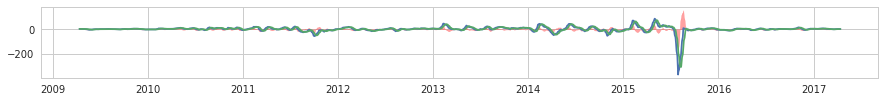

In [82]:
plot_macd(raw_df)

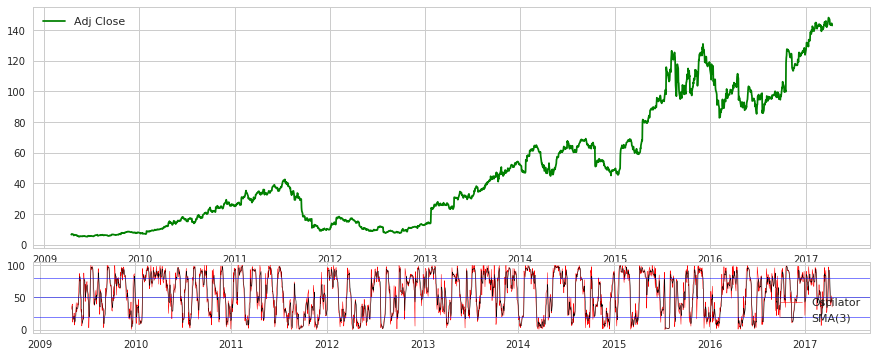

In [83]:
plot_stochasticoscilator(raw_df)

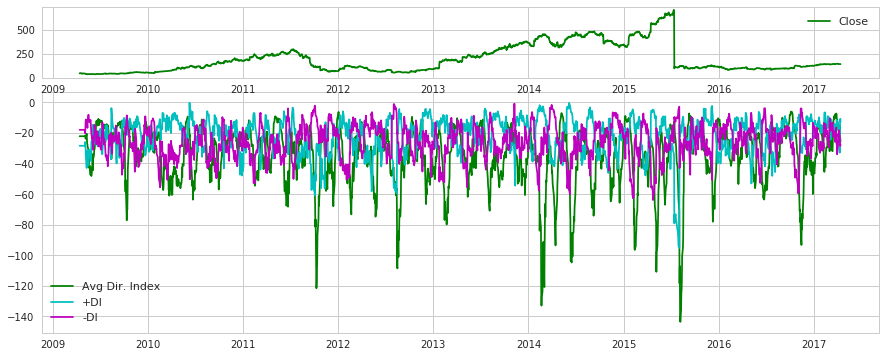

In [84]:
plot_atr(raw_df)

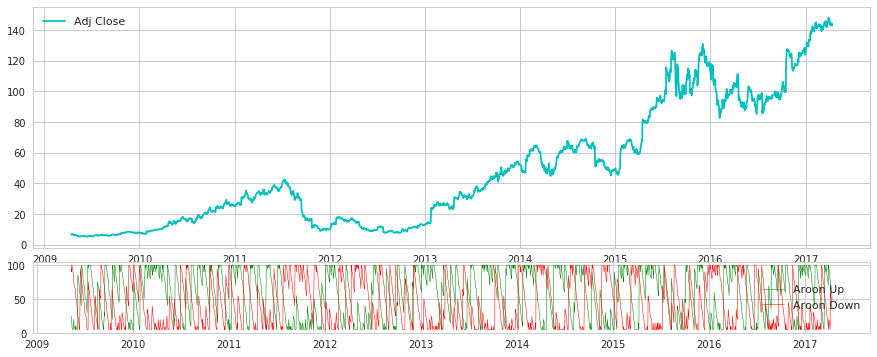

In [85]:
plot_aroon(raw_df)

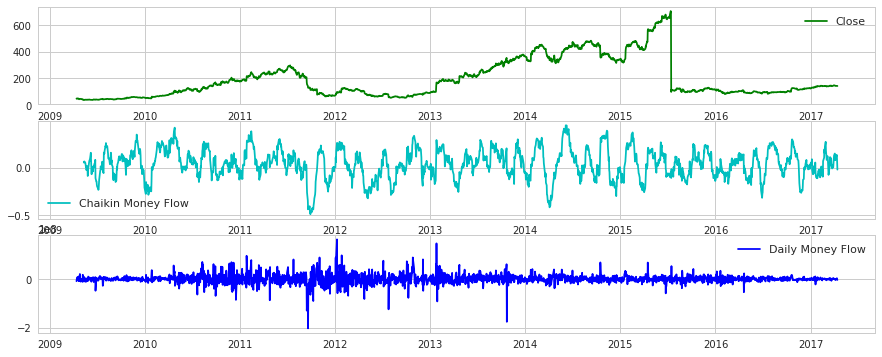

In [86]:
plot_chaikin_money_flow(raw_df)

In [20]:
trial_a = pd.DataFrame()
trial_a["SMA_5"] = raw_df["Close"].rolling(window=5).mean()
trial_a["SMA_30"] = raw_df["Close"].rolling(window=30).mean()
trial_a["SMA_60"] = raw_df["Close"].rolling(window=60).mean()
trial_a["SMA_200"] = raw_df["Close"].rolling(window=200).mean()

trial_a["BOLL_5_UP"] = trial_a["SMA_5"] + (2 * raw_df["Close"].rolling(window=5).std())
trial_a["BOLL_5_DOWN"] = trial_a["SMA_5"] - (2 * raw_df["Close"].rolling(window=5).std())
trial_a["BOLL_30_UP"] = trial_a["SMA_30"] + (2 * raw_df["Close"].rolling(window=30).std())
trial_a["BOLL_30_DOWN"] = trial_a["SMA_30"] - (2 * raw_df["Close"].rolling(window=30).std())
trial_a["BOLL_60_UP"] = trial_a["SMA_60"] + (2 * raw_df["Close"].rolling(window=60).std())
trial_a["BOLL_60_DOWN"] = trial_a["SMA_60"] - (2 * raw_df["Close"].rolling(window=60).std())
trial_a["BOLL_200_UP"] = trial_a["SMA_200"] + (2 * raw_df["Close"].rolling(window=200).std())
trial_a["BOLL_200_DOWN"] = trial_a["SMA_200"] - (2 * raw_df["Close"].rolling(window=200).std())


emaslow, emafast, macd = calc_macd(raw_df["Close"], 26, 12)
trial_a["MACD"] = macd
trial_a["MACD_EMASLOW"] = emaslow
trial_a["MACD_EMAFAST"] = emafast


trial_a["RSI_14"] = rsiFunc(raw_df["Close"], 14)
trial_a["RSI_21"] = rsiFunc(raw_df["Close"], 21)
trial_a["RSI_60"] = rsiFunc(raw_df["Close"], 60)


trial_a["STOCOSCILATOR_14"] = calc_stochasticoscilator(raw_df, 14)
trial_a["STOCOSCILATOR_14_SMA"] = trial_a["STOCOSCILATOR_14"].rolling(window=3).mean()


adx, pdi, ndi = calc_adx(raw_df)
trial_a["ADX"] = adx
trial_a["ADX_PDI"] = pdi
trial_a["ADX_NDI"] = ndi


aroon_up, aroon_down = calc_aroon(raw_df, 20)
trial_a["AROONUP_20"] = aroon_up.values
trial_a["AROONDOWN_20"] = aroon_down.values


cmf, dmf = calc_chaikin_money_flow(raw_df, window=21)
trial_a["CHAIKIN_MFLOW_21"] = cmf
trial_a["DAILY_MFLOW_21"] = dmf

trial_a["RETURN_1"] = ((raw_df["Close"] / raw_df["Close"].shift(1)) - 1)
trial_a["RETURN_30"] = ((raw_df["Close"] / raw_df["Close"].shift(30)) - 1)
trial_a["RETURN_60"] = ((raw_df["Close"] / raw_df["Close"].shift(60)) - 1)
trial_a["RETURN_200"] = ((raw_df["Close"] / raw_df["Close"].shift(200)) - 1)

trial_a["OBV"] = onbalancevolumeFunc(trial_a["RETURN_1"], raw_df["Volume"])

trial_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016 entries, 2009-04-14 to 2017-04-13
Data columns (total 32 columns):
SMA_5                   2012 non-null float64
SMA_30                  1987 non-null float64
SMA_60                  1957 non-null float64
SMA_200                 1817 non-null float64
BOLL_5_UP               2012 non-null float64
BOLL_5_DOWN             2012 non-null float64
BOLL_30_UP              1987 non-null float64
BOLL_30_DOWN            1987 non-null float64
BOLL_60_UP              1957 non-null float64
BOLL_60_DOWN            1957 non-null float64
BOLL_200_UP             1817 non-null float64
BOLL_200_DOWN           1817 non-null float64
MACD                    2016 non-null float64
MACD_EMASLOW            2016 non-null float64
MACD_EMAFAST            2016 non-null float64
RSI_14                  2016 non-null float64
RSI_21                  2016 non-null float64
RSI_60                  2016 non-null float64
STOCOSCILATOR_14        2003 non-null float64
S

In [23]:
trial_a.to_csv?